<a href="https://colab.research.google.com/github/Jonathan9219/Accidentabilidad/blob/main/Proyecto_Accidentabilidad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Instalar librer√≠as necesarias
!pip install openpyxl

# Importar bibliotecas necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from io import BytesIO

# Para preprocesamiento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Para modelado
from sklearn.ensemble import RandomForestClassifier
import joblib
import seaborn as sns

# Para evaluaci√≥n
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

# Configuraci√≥n para visualizaciones
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Ignorar advertencias
import warnings
warnings.filterwarnings('ignore')

print("‚úÖ Entorno configurado correctamente")

‚úÖ Entorno configurado correctamente


In [5]:
URL='https://raw.githubusercontent.com/AleAguirreM/Proyecto-ACCIDENTALIDAD-VIAL/main/AMVA_Accidentalidad_20191022_2.csv'

In [6]:
# Configuraci√≥n de visualizaci√≥n
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## 2. Adquisici√≥n de Datos

# Asume que los datos est√°n en data/raw/
try:
    df = pd.read_csv(URL, sep=';', encoding='latin-1')
    print("Datos cargados exitosamente. Forma:", df.shape)
except FileNotFoundError:
    print("Error: El archivo 'incidentes.csv' no se encontr√≥ en la ruta esperada.")

Datos cargados exitosamente. Forma: (203450, 11)


In [7]:
df

COD_MUNICIPIO MUNICIPIO       FECHA         HORA D√çA DE LA SEMANA  \
0                79.0   BARBOSA  03/01/2015  01:00:00 PM           SABADO   
1                79.0   BARBOSA  07/01/2015  03:00:00 PM        MIERCOLES   
2                79.0   BARBOSA  04/01/2015  04:01:00 AM        DOMINGO     
3                79.0   BARBOSA  05/01/2015  12:00:00 PM        LUNES       
4                79.0   BARBOSA  11/01/2015  01:30:00 PM        DOMINGO     
...               ...       ...         ...          ...              ...   
203445            NaN       NaN         NaN          NaN              NaN   
203446            NaN       NaN         NaN          NaN              NaN   
203447            NaN       NaN         NaN          NaN              NaN   
203448            NaN       NaN         NaN          NaN              NaN   
203449            NaN       NaN         NaN          NaN              NaN   

         CLASE                         DIRECCI√ìN GRAVEDA√ëOSSADA√ëOSS  \
0       CHOQUE        VIA BELLO HATILLO KM16+200            HERIDOS   
1       CHOQUE            HATILLO-BELLO KM 18+00            HERIDOS   
2       CHOQUE  KM 16+395 METROS BARBOSA-HATILLO            HERIDOS   
3       CHOQUE        BELLO- DON MATIAS KM 9+600            HERIDOS   
4       CHOQUE                       LOS ABUELOS              DA√ëOS   
...        ...                               ...                ...   
203445     NaN                               NaN                NaN   
203446     NaN                               NaN                NaN   
203447     NaN                               NaN                NaN   
203448     NaN                               NaN                NaN   
203449     NaN                               NaN                NaN   

                         BARRIO           COMUNA        DISE√ëO  
0                    EL HATILLO  SIN INFORMACI√ìN  TRAMO DE VIA  
1              PARQUE PRINCIPAL  SIN INFORMACI√ìN  TRAMO DE VIA  
2       VIA EL HATILLO-CISNEROS  SIN INFORMACI√ìN  TRAMO DE VIA  
3                    EL HATILLO  SIN INFORMACI√ìN  TRAMO DE VIA  
4              PARQUE PRINCIPAL  SIN INFORMACI√ìN  TRAMO DE VIA  
...                         ...              ...           ...  
203445                      NaN              NaN           NaN  
203446                      NaN              NaN           NaN  
203447                      NaN              NaN           NaN  
203448                      NaN              NaN           NaN  
203449                      NaN              NaN           NaN  

[203450 rows x 11 columns]

In [8]:
df = df.dropna()

In [9]:
def limpiar_y_convertir_hora(serie_hora: pd.Series) -> pd.Series:
    """
    Convierte una serie de horas con diferentes formatos (HH:MM, HH:MM:SS, I:MM:SS p.m.)
    al formato militar unificado 'HH:MM', usando m√©todos vectorizados de Pandas/NumPy.
    """
    # 1. Limpieza inicial: Convertir a string, eliminar espacios y poner en min√∫sculas
    horas = serie_hora.astype(str).str.lower().str.strip()

    # --- Intentos de Parseo Vectorizado ---

    # Intento A: Formato 12 horas con segundos (I:MM:SS p.m./a.m.)
    hora_ampm = pd.to_datetime(horas, format='%I:%M:%S %p', errors='coerce').dt.strftime('%H:%M')

    # Intento B: Formato 24 horas con segundos (HH:MM:SS)
    hora_24h_seg = pd.to_datetime(horas, format='%H:%M:%S', errors='coerce').dt.strftime('%H:%M')

    # Intento C: Formato 24 horas sin segundos (HH:MM)
    hora_24h_sin_seg = pd.to_datetime(horas, format='%H:%M', errors='coerce').dt.strftime('%H:%M')

    # --- Consolidaci√≥n de Resultados (Usando numpy.where para vectorizaci√≥n) ---

    # En numpy.where, los NaT (Not a Time) o NaN de Pandas se convierten en 'nan' strings

    # 2. Priorizar la conversi√≥n AM/PM (Intento A)
    resultado = hora_ampm

    # 3. Rellenar los valores nulos (NaT) de A con los valores v√°lidos del Intento B
    resultado = np.where(resultado.isna(), hora_24h_seg, resultado)

    # 4. Rellenar los valores nulos restantes con los valores v√°lidos del Intento C
    # Nota: Aqu√≠ usamos el 'nan' string, ya que np.where lo produce para valores nulos/NaT
    resultado = np.where(resultado == 'nan', hora_24h_sin_seg, resultado)

    # 5. CORRECCI√ìN CLAVE: Convertir el numpy.ndarray final a pd.Series
    # y limpiar los strings 'nan' a NaN de Pandas para que sean nulos reales.
    resultado_series = pd.Series(resultado, index=serie_hora.index)
    resultado_series = resultado_series.replace('nan', np.nan)

    return resultado_series

# --- Bloque para Aplicar la Funci√≥n (Ejemplo) ---

# Aplicar la funci√≥n a la columna
df['HORA_MILITAR'] = limpiar_y_convertir_hora(df['HORA'])

print("Funci√≥n corregida aplicada exitosamente. Verifica la columna 'HORA_MILITAR'.")
print(df)

Funci√≥n corregida aplicada exitosamente. Verifica la columna 'HORA_MILITAR'.
        COD_MUNICIPIO MUNICIPIO       FECHA         HORA D√çA DE LA SEMANA  \
0                79.0   BARBOSA  03/01/2015  01:00:00 PM           SABADO   
1                79.0   BARBOSA  07/01/2015  03:00:00 PM        MIERCOLES   
2                79.0   BARBOSA  04/01/2015  04:01:00 AM        DOMINGO     
3                79.0   BARBOSA  05/01/2015  12:00:00 PM        LUNES       
4                79.0   BARBOSA  11/01/2015  01:30:00 PM        DOMINGO     
...               ...       ...         ...          ...              ...   
203430          631.0  SABANETA  30/08/2018     18:45:00           JUEVES   
203431          631.0  SABANETA  30/08/2018     18:45:00           JUEVES   
203432          631.0  SABANETA  31/08/2018     17:00:00          VIERNES   
203433          631.0  SABANETA  31/08/2018     18:10:00          VIERNES   
203434          631.0  SABANETA   2/08/2018     20:15:00           JUEVES 

In [10]:
COLUMNA = 'FECHA'

# 1. Conversi√≥n Robusta a Datetime (Maneja la mezcla de formatos)
# 'mixed' permite inferir si tiene solo fecha o fecha y hora.
# 'errors='coerce' convierte cualquier string imposible de parsear a NaT (Nulo).
df['FECHA_HORA_FINAL'] = pd.to_datetime(
    df[COLUMNA],
    format='mixed',
    dayfirst=True,  # Asume que el d√≠a viene primero (DD/MM/YYYY)
    errors='coerce'
)

# 2. Normalizaci√≥n para Dejar SOLO la Fecha
# .dt.normalize() elimina la hora (establece la hora a 00:00:00) de todas las filas.
df['SOLO_FECHA'] = df['FECHA_HORA_FINAL'].dt.normalize()

# --- Verificaci√≥n ---
print("--- Verificaci√≥n del Tipo de Dato y Formato ---")
print(f"Tipo de dato de la nueva columna: {df['SOLO_FECHA'].dtype}")
print("Muestra de los datos (la hora debe ser 00:00:00 o NaT):")
print(df[['FECHA_HORA_FINAL', 'SOLO_FECHA']].head())

--- Verificaci√≥n del Tipo de Dato y Formato ---
Tipo de dato de la nueva columna: datetime64[ns]
Muestra de los datos (la hora debe ser 00:00:00 o NaT):
  FECHA_HORA_FINAL SOLO_FECHA
0       2015-01-03 2015-01-03
1       2015-01-07 2015-01-07
2       2015-01-04 2015-01-04
3       2015-01-05 2015-01-05
4       2015-01-11 2015-01-11


In [11]:
# Convertir la columna al tipo datetime
df['SOLO_FECHA'] = pd.to_datetime(df['SOLO_FECHA'])

print(df['SOLO_FECHA'].dtype)

datetime64[ns]


In [12]:
print(df['D√çA DE LA SEMANA'].unique())

['SABADO' 'MIERCOLES' 'DOMINGO  ' 'LUNES    ' 'MARTES   ' 'JUEVES   '
 'VIERNES  ' 'JUEVES' 'VIERNES' 'MARTES' 'LUNES' 'DOMINGO']


In [13]:
# 1. Aplicar .str.strip() a la columna para eliminar espacios
df['D√çA DE LA SEMANA'] = df['D√çA DE LA SEMANA'].astype(str).str.strip()

# --- Verificaci√≥n ---

# 2. Obtener los valores √∫nicos corregidos (deber√≠an ser solo 7 ahora)
valores_unicos_corregidos = df['D√çA DE LA SEMANA'].unique()

In [14]:
df

COD_MUNICIPIO MUNICIPIO       FECHA         HORA D√çA DE LA SEMANA  \
0                79.0   BARBOSA  03/01/2015  01:00:00 PM           SABADO   
1                79.0   BARBOSA  07/01/2015  03:00:00 PM        MIERCOLES   
2                79.0   BARBOSA  04/01/2015  04:01:00 AM          DOMINGO   
3                79.0   BARBOSA  05/01/2015  12:00:00 PM            LUNES   
4                79.0   BARBOSA  11/01/2015  01:30:00 PM          DOMINGO   
...               ...       ...         ...          ...              ...   
203430          631.0  SABANETA  30/08/2018     18:45:00           JUEVES   
203431          631.0  SABANETA  30/08/2018     18:45:00           JUEVES   
203432          631.0  SABANETA  31/08/2018     17:00:00          VIERNES   
203433          631.0  SABANETA  31/08/2018     18:10:00          VIERNES   
203434          631.0  SABANETA   2/08/2018     20:15:00           JUEVES   

                 CLASE                         DIRECCI√ìN GRAVEDA√ëOSSADA√ëOSS  \
0               CHOQUE        VIA BELLO HATILLO KM16+200            HERIDOS   
1               CHOQUE            HATILLO-BELLO KM 18+00            HERIDOS   
2               CHOQUE  KM 16+395 METROS BARBOSA-HATILLO            HERIDOS   
3               CHOQUE        BELLO- DON MATIAS KM 9+600            HERIDOS   
4               CHOQUE                       LOS ABUELOS              DA√ëOS   
...                ...                               ...                ...   
203430          CHOQUE                   CL 77 Sur CR 45            HERIDOS   
203431          CHOQUE                   CL 77 Sur CR 45            HERIDOS   
203432  CAIDA OCUPANTE                   CL 52 Sur CR 44            HERIDOS   
203433     VOLCAMIENTO                   CR 49 CL 51 Sur            HERIDOS   
203434       ATROPELLO                   CR 49 CL 75 Sur            MUERTOS   

                         BARRIO           COMUNA            DISE√ëO  \
0                    EL HATILLO  SIN INFORMACI√ìN      TRAMO DE VIA   
1              PARQUE PRINCIPAL  SIN INFORMACI√ìN      TRAMO DE VIA   
2       VIA EL HATILLO-CISNEROS  SIN INFORMACI√ìN      TRAMO DE VIA   
3                    EL HATILLO  SIN INFORMACI√ìN      TRAMO DE VIA   
4              PARQUE PRINCIPAL  SIN INFORMACI√ìN      TRAMO DE VIA   
...                         ...              ...               ...   
203430          SIN INFORMACI√ìN  SIN INFORMACI√ìN  SIN INFORMACI√ìN    
203431          SIN INFORMACI√ìN  SIN INFORMACI√ìN  SIN INFORMACI√ìN    
203432          SIN INFORMACI√ìN  SIN INFORMACI√ìN  SIN INFORMACI√ìN    
203433          SIN INFORMACI√ìN  SIN INFORMACI√ìN  SIN INFORMACI√ìN    
203434          SIN INFORMACI√ìN  SIN INFORMACI√ìN  SIN INFORMACI√ìN    

       HORA_MILITAR FECHA_HORA_FINAL SOLO_FECHA  
0             13:00       2015-01-03 2015-01-03  
1             15:00       2015-01-07 2015-01-07  
2             04:01       2015-01-04 2015-01-04  
3             12:00       2015-01-05 2015-01-05  
4             13:30       2015-01-11 2015-01-11  
...             ...              ...        ...  
203430        18:45       2018-08-30 2018-08-30  
203431        18:45       2018-08-30 2018-08-30  
203432        17:00       2018-08-31 2018-08-31  
203433        18:10       2018-08-31 2018-08-31  
203434        20:15       2018-08-02 2018-08-02  

[203385 rows x 14 columns]

In [16]:
df = df.drop(['FECHA', 'FECHA_HORA_FINAL', 'HORA'], axis=1)

In [19]:
df

COD_MUNICIPIO MUNICIPIO DIA_SEMANA           CLASE  \
0                79.0   BARBOSA     SABADO          CHOQUE   
1                79.0   BARBOSA  MIERCOLES          CHOQUE   
2                79.0   BARBOSA    DOMINGO          CHOQUE   
3                79.0   BARBOSA      LUNES          CHOQUE   
4                79.0   BARBOSA    DOMINGO          CHOQUE   
...               ...       ...        ...             ...   
203430          631.0  SABANETA     JUEVES          CHOQUE   
203431          631.0  SABANETA     JUEVES          CHOQUE   
203432          631.0  SABANETA    VIERNES  CAIDA OCUPANTE   
203433          631.0  SABANETA    VIERNES     VOLCAMIENTO   
203434          631.0  SABANETA     JUEVES       ATROPELLO   

                               DIRECCI√ìN GRAVEDA√ëOSSADA√ëOSS  \
0             VIA BELLO HATILLO KM16+200            HERIDOS   
1                 HATILLO-BELLO KM 18+00            HERIDOS   
2       KM 16+395 METROS BARBOSA-HATILLO            HERIDOS   
3             BELLO- DON MATIAS KM 9+600            HERIDOS   
4                            LOS ABUELOS              DA√ëOS   
...                                  ...                ...   
203430                   CL 77 Sur CR 45            HERIDOS   
203431                   CL 77 Sur CR 45            HERIDOS   
203432                   CL 52 Sur CR 44            HERIDOS   
203433                   CR 49 CL 51 Sur            HERIDOS   
203434                   CR 49 CL 75 Sur            MUERTOS   

                         BARRIO           COMUNA            DISE√ëO HORA_STR  \
0                    EL HATILLO  SIN INFORMACI√ìN      TRAMO DE VIA    13:00   
1              PARQUE PRINCIPAL  SIN INFORMACI√ìN      TRAMO DE VIA    15:00   
2       VIA EL HATILLO-CISNEROS  SIN INFORMACI√ìN      TRAMO DE VIA    04:01   
3                    EL HATILLO  SIN INFORMACI√ìN      TRAMO DE VIA    12:00   
4              PARQUE PRINCIPAL  SIN INFORMACI√ìN      TRAMO DE VIA    13:30   
...                         ...              ...               ...      ...   
203430          SIN INFORMACI√ìN  SIN INFORMACI√ìN  SIN INFORMACI√ìN     18:45   
203431          SIN INFORMACI√ìN  SIN INFORMACI√ìN  SIN INFORMACI√ìN     18:45   
203432          SIN INFORMACI√ìN  SIN INFORMACI√ìN  SIN INFORMACI√ìN     17:00   
203433          SIN INFORMACI√ìN  SIN INFORMACI√ìN  SIN INFORMACI√ìN     18:10   
203434          SIN INFORMACI√ìN  SIN INFORMACI√ìN  SIN INFORMACI√ìN     20:15   

            FECHA  
0      2015-01-03  
1      2015-01-07  
2      2015-01-04  
3      2015-01-05  
4      2015-01-11  
...           ...  
203430 2018-08-30  
203431 2018-08-30  
203432 2018-08-31  
203433 2018-08-31  
203434 2018-08-02  

[203385 rows x 11 columns]

In [24]:
df.rename(columns={
    'HORA_MILITAR': 'HORA_STR',
    'GRAVEDA√ëOSSADA√ëOSS': 'GRAVEDAD_DA√ëOS',
    'D√çA DE LA SEMANA': 'DIA_SEMANA',
    'SOLO_FECHA': 'FECHA',
}, inplace=True)

In [21]:
# **A. Limpieza de Tiempos y Fechas**
# Convertir 'FECHA' a datetime y crear nuevas variables temporales
df['MES'] = df['FECHA'].dt.to_period('M')
df['A√ëO'] = df['FECHA'].dt.year
df['DIA_MES'] = df['FECHA'].dt.day


In [25]:
df

COD_MUNICIPIO MUNICIPIO DIA_SEMANA           CLASE  \
0                79.0   BARBOSA     SABADO          CHOQUE   
1                79.0   BARBOSA  MIERCOLES          CHOQUE   
2                79.0   BARBOSA    DOMINGO          CHOQUE   
3                79.0   BARBOSA      LUNES          CHOQUE   
4                79.0   BARBOSA    DOMINGO          CHOQUE   
...               ...       ...        ...             ...   
203430          631.0  SABANETA     JUEVES          CHOQUE   
203431          631.0  SABANETA     JUEVES          CHOQUE   
203432          631.0  SABANETA    VIERNES  CAIDA OCUPANTE   
203433          631.0  SABANETA    VIERNES     VOLCAMIENTO   
203434          631.0  SABANETA     JUEVES       ATROPELLO   

                               DIRECCI√ìN GRAVEDAD_DA√ëOS  \
0             VIA BELLO HATILLO KM16+200        HERIDOS   
1                 HATILLO-BELLO KM 18+00        HERIDOS   
2       KM 16+395 METROS BARBOSA-HATILLO        HERIDOS   
3             BELLO- DON MATIAS KM 9+600        HERIDOS   
4                            LOS ABUELOS          DA√ëOS   
...                                  ...            ...   
203430                   CL 77 Sur CR 45        HERIDOS   
203431                   CL 77 Sur CR 45        HERIDOS   
203432                   CL 52 Sur CR 44        HERIDOS   
203433                   CR 49 CL 51 Sur        HERIDOS   
203434                   CR 49 CL 75 Sur        MUERTOS   

                         BARRIO           COMUNA            DISE√ëO HORA_STR  \
0                    EL HATILLO  SIN INFORMACI√ìN      TRAMO DE VIA    13:00   
1              PARQUE PRINCIPAL  SIN INFORMACI√ìN      TRAMO DE VIA    15:00   
2       VIA EL HATILLO-CISNEROS  SIN INFORMACI√ìN      TRAMO DE VIA    04:01   
3                    EL HATILLO  SIN INFORMACI√ìN      TRAMO DE VIA    12:00   
4              PARQUE PRINCIPAL  SIN INFORMACI√ìN      TRAMO DE VIA    13:30   
...                         ...              ...               ...      ...   
203430          SIN INFORMACI√ìN  SIN INFORMACI√ìN  SIN INFORMACI√ìN     18:45   
203431          SIN INFORMACI√ìN  SIN INFORMACI√ìN  SIN INFORMACI√ìN     18:45   
203432          SIN INFORMACI√ìN  SIN INFORMACI√ìN  SIN INFORMACI√ìN     17:00   
203433          SIN INFORMACI√ìN  SIN INFORMACI√ìN  SIN INFORMACI√ìN     18:10   
203434          SIN INFORMACI√ìN  SIN INFORMACI√ìN  SIN INFORMACI√ìN     20:15   

            FECHA      MES   A√ëO  DIA_MES  
0      2015-01-03  2015-01  2015        3  
1      2015-01-07  2015-01  2015        7  
2      2015-01-04  2015-01  2015        4  
3      2015-01-05  2015-01  2015        5  
4      2015-01-11  2015-01  2015       11  
...           ...      ...   ...      ...  
203430 2018-08-30  2018-08  2018       30  
203431 2018-08-30  2018-08  2018       30  
203432 2018-08-31  2018-08  2018       31  
203433 2018-08-31  2018-08  2018       31  
203434 2018-08-02  2018-08  2018        2  

[203385 rows x 14 columns]

In [26]:

# Ejecutar carga de datos
print("üöó Cargando datos de accidentalidad desde GitHub...")
df_accidentalidad = df.copy()

if df_accidentalidad is not None:
    print("\nüîç Primeras 5 filas del dataset:")
    display(df_accidentalidad.head())

    print("\nüìã Informaci√≥n del dataset:")
    print(df_accidentalidad.info())

    print("\nüéØ Distribuci√≥n de GRAVEDAD_DA√ëOS:")
    display(df_accidentalidad['GRAVEDAD_DA√ëOS'].value_counts())
else:
    print("‚ùå No se pudieron cargar los datos. El an√°lisis no puede continuar.")

üöó Cargando datos de accidentalidad desde GitHub...

üîç Primeras 5 filas del dataset:


COD_MUNICIPIO MUNICIPIO DIA_SEMANA   CLASE  \
0           79.0   BARBOSA     SABADO  CHOQUE   
1           79.0   BARBOSA  MIERCOLES  CHOQUE   
2           79.0   BARBOSA    DOMINGO  CHOQUE   
3           79.0   BARBOSA      LUNES  CHOQUE   
4           79.0   BARBOSA    DOMINGO  CHOQUE   

                          DIRECCI√ìN GRAVEDAD_DA√ëOS                   BARRIO  \
0        VIA BELLO HATILLO KM16+200        HERIDOS               EL HATILLO   
1            HATILLO-BELLO KM 18+00        HERIDOS         PARQUE PRINCIPAL   
2  KM 16+395 METROS BARBOSA-HATILLO        HERIDOS  VIA EL HATILLO-CISNEROS   
3        BELLO- DON MATIAS KM 9+600        HERIDOS               EL HATILLO   
4                       LOS ABUELOS          DA√ëOS         PARQUE PRINCIPAL   

            COMUNA        DISE√ëO HORA_STR      FECHA      MES   A√ëO  DIA_MES  
0  SIN INFORMACI√ìN  TRAMO DE VIA    13:00 2015-01-03  2015-01  2015        3  
1  SIN INFORMACI√ìN  TRAMO DE VIA    15:00 2015-01-07  2015-01  2015        7  
2  SIN INFORMACI√ìN  TRAMO DE VIA    04:01 2015-01-04  2015-01  2015        4  
3  SIN INFORMACI√ìN  TRAMO DE VIA    12:00 2015-01-05  2015-01  2015        5  
4  SIN INFORMACI√ìN  TRAMO DE VIA    13:30 2015-01-11  2015-01  2015       11


üìã Informaci√≥n del dataset:
<class 'pandas.core.frame.DataFrame'>
Index: 203385 entries, 0 to 203434
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   COD_MUNICIPIO   203385 non-null  float64       
 1   MUNICIPIO       203385 non-null  object        
 2   DIA_SEMANA      203385 non-null  object        
 3   CLASE           203385 non-null  object        
 4   DIRECCI√ìN       203385 non-null  object        
 5   GRAVEDAD_DA√ëOS  203385 non-null  object        
 6   BARRIO          203385 non-null  object        
 7   COMUNA          203385 non-null  object        
 8   DISE√ëO          203385 non-null  object        
 9   HORA_STR        54886 non-null   object        
 10  FECHA           203385 non-null  datetime64[ns]
 11  MES             203385 non-null  period[M]     
 12  A√ëO             203385 non-null  int32         
 13  DIA_MES         203385 non-null  int32         
dtypes: da

GRAVEDAD_DA√ëOS
HERIDOS    101378
DA√ëOS      100927
MUERTOS      1080
Name: count, dtype: int64


üìä AN√ÅLISIS EXPLORATORIO R√ÅPIDO


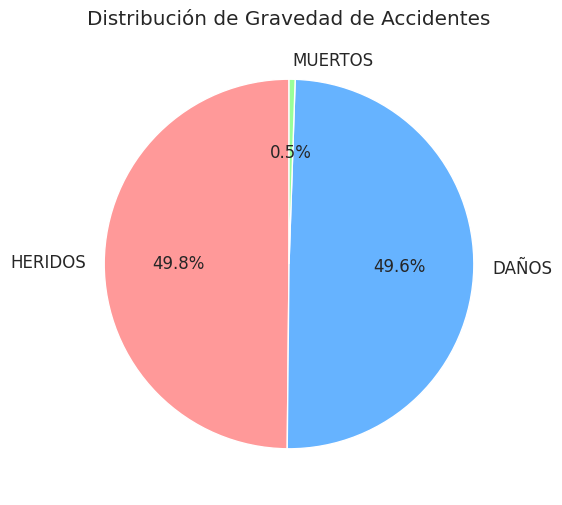

KeyError: 'FRANJA_HORARIA'

<Figure size 1200x600 with 0 Axes>

In [27]:
# =============================================================================
# BLOQUE 3: AN√ÅLISIS EXPLORATORIO R√ÅPIDO
# =============================================================================

def analisis_rapido(data):
    """
    Realiza un an√°lisis exploratorio r√°pido de los datos.

    Args:
        data (pandas.DataFrame): Datos de accidentalidad
    """
    print("\n" + "="*50)
    print("üìä AN√ÅLISIS EXPLORATORIO R√ÅPIDO")
    print("="*50)

    # 1. Distribuci√≥n de gravedad
    plt.figure(figsize=(10, 6))
    gravedad_counts = data['GRAVEDAD_DA√ëOS'].value_counts()
    colors = ['#ff9999', '#66b3ff', '#99ff99']
    plt.pie(gravedad_counts.values, labels=gravedad_counts.index, autopct='%1.1f%%',
            startangle=90, colors=colors)
    plt.title('Distribuci√≥n de Gravedad de Accidentes')
    plt.show()

    # 2. Accidentes por franja horaria
    plt.figure(figsize=(12, 6))
    franja_counts = data['FRANJA_HORARIA'].value_counts()
    sns.barplot(x=franja_counts.values, y=franja_counts.index, palette='viridis')
    plt.title('Cantidad de Accidentes por Franja Horaria')
    plt.xlabel('N√∫mero de Accidentes')
    plt.ylabel('Franja Horaria')
    plt.show()

    # 3. Top 10 tipos de accidente
    plt.figure(figsize=(12, 6))
    clase_counts = data['CLASE'].value_counts().head(10)
    sns.barplot(x=clase_counts.values, y=clase_counts.index, palette='rocket')
    plt.title('Tipos de Accidentes M√°s Frecuentes (Top 10)')
    plt.xlabel('N√∫mero de Accidentes')
    plt.ylabel('Tipo de Accidente')
    plt.show()

    # 4. Top 10 comunas con m√°s accidentes
    plt.figure(figsize=(12, 6))
    comuna_counts = data['COMUNA'].value_counts().head(10)
    sns.barplot(x=comuna_counts.values, y=comuna_counts.index, palette='coolwarm')
    plt.title('Comunas con Mayor N√∫mero de Accidentes (Top 10)')
    plt.xlabel('N√∫mero de Accidentes')
    plt.ylabel('Comuna')
    plt.show()

# Ejecutar an√°lisis r√°pido
if df_accidentalidad is not None:
    analisis_rapido(df_accidentalidad)

In [ ]:
# =============================================================================
# BLOQUE 4: PREPARACI√ìN DE DATOS
# =============================================================================

def preparar_datos(data):
    """
    Prepara los datos para modelado con Random Forest.

    Args:
        data (pandas.DataFrame): Datos de accidentalidad

    Returns:
        tuple: X_train, X_test, y_train, y_test, preprocessor
    """
    print("\n" + "="*50)
    print("üîß PREPARANDO DATOS PARA RANDOM FOREST")
    print("="*50)

    # Crear copia para no modificar el original
    df_model = data.copy()

    # 1. Definir variable objetivo (binaria: HERIDOS/MUERTOS vs DA√ëOS)
    df_model['TARGET_HERIDOS'] = (df_model['GRAVEDAD_DA√ëOS'].isin(['HERIDOS', 'MUERTOS'])).astype(int)

    print("üéØ Variable objetivo creada:")
    print(f"   - 0 (Solo da√±os): {(df_model['TARGET_HERIDOS'] == 0).sum()} accidentes")
    print(f"   - 1 (Con heridos/muertos): {(df_model['TARGET_HERIDOS'] == 1).sum()} accidentes")
    print(f"   - Proporci√≥n de heridos: {df_model['TARGET_HERIDOS'].mean():.2%}")

    # 2. Seleccionar caracter√≠sticas (usando las columnas disponibles)
    features = ['MES', 'DIA_SEMANA_NUM', 'HORA_NUM', 'CLASE', 'COMUNA']
    X = df_model[features]
    y = df_model['TARGET_HERIDOS']

    print(f"\nüìã Caracter√≠sticas seleccionadas: {features}")

    # 3. Dividir en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )

    print(f"üìö Conjunto de entrenamiento: {X_train.shape[0]} muestras")
    print(f"üß™ Conjunto de prueba: {X_test.shape[0]} muestras")

    # 4. Configurar preprocesamiento (sin imputers ya que no hay nulos)
    numeric_features = ['MES', 'DIA_SEMANA_NUM', 'HORA_NUM']
    categorical_features = ['CLASE', 'COMUNA']

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
        ])

    # 5. Probar preprocesamiento
    X_train_preprocessed = preprocessor.fit_transform(X_train)
    print(f"‚úÖ Forma despu√©s del preprocesamiento: {X_train_preprocessed.shape}")

    return X_train, X_test, y_train, y_test, preprocessor

# Ejecutar preparaci√≥n de datos
if df_accidentalidad is not None:
    X_train, X_test, y_train, y_test, preprocessor = preparar_datos(df_accidentalidad)


üîß PREPARANDO DATOS PARA RANDOM FOREST
üéØ Variable objetivo creada:
   - 0 (Solo da√±os): 64165 accidentes
   - 1 (Con heridos/muertos): 79541 accidentes
   - Proporci√≥n de heridos: 55.35%

üìã Caracter√≠sticas seleccionadas: ['MES', 'DIA_SEMANA_NUM', 'HORA_NUM', 'CLASE', 'COMUNA']
üìö Conjunto de entrenamiento: 114964 muestras
üß™ Conjunto de prueba: 28742 muestras
‚úÖ Forma despu√©s del preprocesamiento: (114964, 34)



ü§ñ ENTRENAMIENTO CON RANDOM FOREST
üöÄ Entrenando Random Forest con n_estimators=5...

üìä RESULTADOS DEL MODELO:
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ     M√©trica      ‚îÇ  Valor     ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ Exactitud        ‚îÇ   0.7625   ‚îÇ
‚îÇ Precisi√≥n        ‚îÇ   0.9661   ‚îÇ
‚îÇ Sensibilidad     ‚îÇ   0.5917   ‚îÇ
‚îÇ F1-Score         ‚îÇ   0.7339   ‚îÇ
‚îÇ AUC-ROC          ‚îÇ   0.8227   ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò


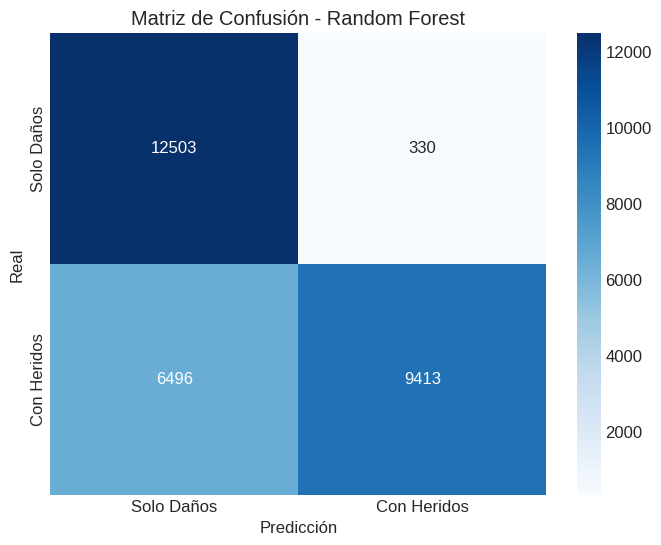

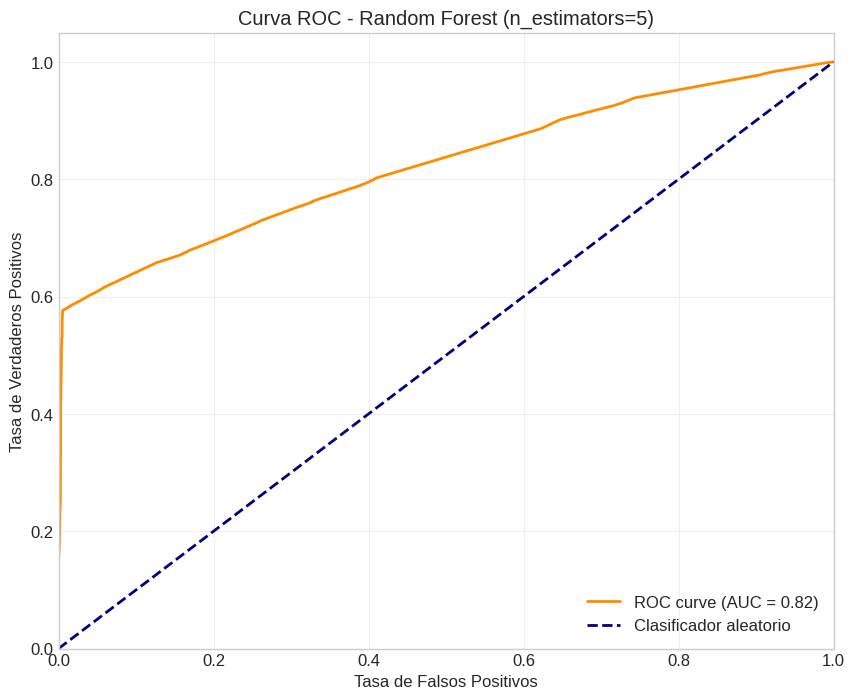


üìÑ INFORME DE CLASIFICACI√ìN:
              precision    recall  f1-score   support

  Solo Da√±os       0.66      0.97      0.79     12833
 Con Heridos       0.97      0.59      0.73     15909

    accuracy                           0.76     28742
   macro avg       0.81      0.78      0.76     28742
weighted avg       0.83      0.76      0.76     28742



In [ ]:
# =============================================================================
# BLOQUE 5: ENTRENAMIENTO CON RANDOM FOREST
# =============================================================================

def entrenar_random_forest(X_train, X_test, y_train, y_test, preprocessor):
    """
    Entrena y eval√∫a un modelo de Random Forest con n_estimators=5.

    Args:
        X_train, X_test, y_train, y_test: Conjuntos de datos
        preprocessor: Transformador de preprocesamiento

    Returns:
        tuple: Modelo entrenado, resultados
    """
    print("\n" + "="*50)
    print("ü§ñ ENTRENAMIENTO CON RANDOM FOREST")
    print("="*50)

    # 1. Crear pipeline con Random Forest
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(
            n_estimators=5,      # Solo 5 √°rboles como solicitado
            random_state=42,
            max_depth=5          # Limitamos profundidad para evitar overfitting
        ))
    ])

    print("üöÄ Entrenando Random Forest con n_estimators=5...")

    # 2. Entrenar modelo
    model.fit(X_train, y_train)

    # 3. Hacer predicciones
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # 4. Calcular m√©tricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print("\nüìä RESULTADOS DEL MODELO:")
    print("‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê")
    print("‚îÇ     M√©trica      ‚îÇ  Valor     ‚îÇ")
    print("‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§")
    print(f"‚îÇ Exactitud        ‚îÇ   {accuracy:.4f}   ‚îÇ")
    print(f"‚îÇ Precisi√≥n        ‚îÇ   {precision:.4f}   ‚îÇ")
    print(f"‚îÇ Sensibilidad     ‚îÇ   {recall:.4f}   ‚îÇ")
    print(f"‚îÇ F1-Score         ‚îÇ   {f1:.4f}   ‚îÇ")
    print(f"‚îÇ AUC-ROC          ‚îÇ   {roc_auc:.4f}   ‚îÇ")
    print("‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò")

    # 5. Matriz de confusi√≥n
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Solo Da√±os', 'Con Heridos'],
                yticklabels=['Solo Da√±os', 'Con Heridos'])
    plt.title('Matriz de Confusi√≥n - Random Forest')
    plt.xlabel('Predicci√≥n')
    plt.ylabel('Real')
    plt.show()

    # 6. Curva ROC
    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Clasificador aleatorio')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Curva ROC - Random Forest (n_estimators=5)')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()

    # 7. Reporte de clasificaci√≥n
    print("\nüìÑ INFORME DE CLASIFICACI√ìN:")
    print(classification_report(y_test, y_pred, target_names=['Solo Da√±os', 'Con Heridos']))

    resultados = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }

    return model, resultados

# Ejecutar entrenamiento
if 'X_train' in locals():
    modelo_rf, resultados_rf = entrenar_random_forest(
        X_train, X_test, y_train, y_test, preprocessor
    )

In [ ]:
# =============================================================================
# BLOQUE 6: PREDICCIONES Y GUARDADO
# =============================================================================

def hacer_predicciones(modelo):
    """
    Realiza predicciones con nuevos datos de ejemplo.

    Args:
        modelo: Modelo entrenado de Random Forest
    """
    print("\n" + "="*50)
    print("üîÆ PREDICCIONES CON NUEVOS DATOS")
    print("="*50)

    # Crear datos de ejemplo para predicci√≥n
    nuevos_accidentes = pd.DataFrame({
        'MES': [1, 7, 12, 3],  # Enero, Julio, Diciembre, Marzo
        'DIA_SEMANA_NUM': [6, 2, 4, 1],  # Domingo, Martes, Jueves, Lunes
        'HORA_NUM': [20, 14, 8, 18],  # Noche, Tarde, Ma√±ana, Noche
        'CLASE': ['CHOQUE', 'ATROPELLO', 'CHOQUE', 'VOLCAMIENTO'],
        'COMUNA': ['LAURELES ESTADIO', 'LA CANDELARIA', 'CASTILLA', 'ROBLEDO']
    })

    print("üìã Nuevos accidentes a predecir:")
    display(nuevos_accidentes)

    # Hacer predicciones
    try:
        predicciones = modelo.predict(nuevos_accidentes)
        probabilidades = modelo.predict_proba(nuevos_accidentes)[:, 1]

        # Crear DataFrame con resultados
        resultados = nuevos_accidentes.copy()
        resultados['PREDICCION'] = ['CON HERIDOS' if p == 1 else 'SOLO DA√ëOS' for p in predicciones]
        resultados['PROBABILIDAD_HERIDOS'] = [f"{prob:.1%}" for prob in probabilidades]
        resultados['RIESGO'] = ['ALTO' if prob > 0.7 else 'MEDIO' if prob > 0.5 else 'BAJO'
                               for prob in probabilidades]

        print("\nüéØ RESULTADOS DE PREDICCI√ìN:")
        display(resultados)

        return resultados

    except Exception as e:
        print(f"‚ùå Error en las predicciones: {e}")
        return None

def guardar_modelo(modelo, filename='modelo_random_forest.joblib'):
    """
    Guarda el modelo entrenado.

    Args:
        modelo: Modelo entrenado
        filename: Nombre del archivo
    """
    try:
        joblib.dump(modelo, filename)
        print(f"‚úÖ Modelo guardado exitosamente como: '{filename}'")
        return True
    except Exception as e:
        print(f"‚ùå Error al guardar el modelo: {e}")
        return False

# Ejecutar predicciones y guardado
if 'modelo_rf' in locals():
    # Hacer predicciones
    resultados_prediccion = hacer_predicciones(modelo_rf)

    # Guardar modelo
    guardar_modelo(modelo_rf)


üîÆ PREDICCIONES CON NUEVOS DATOS
üìã Nuevos accidentes a predecir:


MES  DIA_SEMANA_NUM  HORA_NUM        CLASE            COMUNA
0    1               6        20       CHOQUE  LAURELES ESTADIO
1    7               2        14    ATROPELLO     LA CANDELARIA
2   12               4         8       CHOQUE          CASTILLA
3    3               1        18  VOLCAMIENTO           ROBLEDO


üéØ RESULTADOS DE PREDICCI√ìN:


MES  DIA_SEMANA_NUM  HORA_NUM        CLASE            COMUNA   PREDICCION  \
0    1               6        20       CHOQUE  LAURELES ESTADIO   SOLO DA√ëOS   
1    7               2        14    ATROPELLO     LA CANDELARIA  CON HERIDOS   
2   12               4         8       CHOQUE          CASTILLA   SOLO DA√ëOS   
3    3               1        18  VOLCAMIENTO           ROBLEDO  CON HERIDOS   

  PROBABILIDAD_HERIDOS RIESGO  
0                43.6%   BAJO  
1                89.1%   ALTO  
2                47.3%   BAJO  
3                90.0%   ALTO

‚úÖ Modelo guardado exitosamente como: 'modelo_random_forest.joblib'


In [ ]:
# =============================================================================
# BLOQUE 7: AN√ÅLISIS DE IMPORTANCIA DE VARIABLES
# =============================================================================

def analizar_importancia_variables(modelo, preprocessor):
    """
    Analiza la importancia de las variables en el modelo Random Forest.

    Args:
        modelo: Modelo entrenado
        preprocessor: Transformador de preprocesamiento
    """
    print("\n" + "="*50)
    print("üîç AN√ÅLISIS DE IMPORTANCIA DE VARIABLES")
    print("="*50)

    # Extraer el modelo Random Forest del pipeline
    rf_model = modelo.named_steps['classifier']

    # Obtener nombres de caracter√≠sticas despu√©s del preprocesamiento
    numeric_features = ['MES', 'DIA_SEMANA_NUM', 'HORA_NUM']
    categorical_features = ['CLASE', 'COMUNA']

    # Obtener nombres de caracter√≠sticas categ√≥ricas despu√©s de one-hot encoding
    ohe = modelo.named_steps['preprocessor'].named_transformers_['cat']
    cat_feature_names = ohe.get_feature_names_out(categorical_features)

    # Combinar nombres de caracter√≠sticas
    feature_names = numeric_features + list(cat_feature_names)

    # Obtener importancias
    importancias = rf_model.feature_importances_

    # Crear DataFrame
    importancia_df = pd.DataFrame({
        'Variable': feature_names,
        'Importancia': importancias
    }).sort_values('Importancia', ascending=False)

    print("üìä Variables m√°s importantes para predecir accidentes con heridos:")
    display(importancia_df.head(10))

    # Visualizar top 10 variables m√°s importantes
    plt.figure(figsize=(12, 8))
    top_10 = importancia_df.head(10)
    sns.barplot(x='Importancia', y='Variable', data=top_10, palette='viridis')
    plt.title('Top 10 Variables M√°s Importantes - Random Forest')
    plt.xlabel('Importancia')
    plt.ylabel('Variable')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    return importancia_df

# Ejecutar an√°lisis de importancia
if all(var in locals() for var in ['modelo_rf', 'preprocessor']):
    importancia_variables = analizar_importancia_variables(modelo_rf, preprocessor)

In [ ]:
# =============================================================================
# BLOQUE 8: RESUMEN EJECUTIVO
# =============================================================================

def generar_resumen_final(df_accidentalidad, resultados):
    """
    Genera un resumen ejecutivo del an√°lisis.

    Args:
        df_accidentalidad: DataFrame con los datos
        resultados: Resultados del modelo
    """
    print("\n" + "="*60)
    print("üìä RESUMEN EJECUTIVO DEL PROYECTO")
    print("="*60)

    # Estad√≠sticas generales
    total_accidentes = len(df_accidentalidad)
    accidentes_con_heridos = len(df_accidentalidad[df_accidentalidad['GRAVEDAD_DA√ëOS'].isin(['HERIDOS', 'MUERTOS'])])
    tasa_heridos = accidentes_con_heridos / total_accidentes

    print("üìà ESTAD√çSTICAS GENERALES:")
    print(f"   ‚Ä¢ Total de accidentes analizados: {total_accidentes:,}")
    print(f"   ‚Ä¢ Accidentes con heridos/muertos: {accidentes_con_heridos:,}")
    print(f"   ‚Ä¢ Tasa de accidentes con heridos: {tasa_heridos:.2%}")

    print(f"\nü§ñ MODELO RANDOM FOREST:")
    print(f"   ‚Ä¢ n_estimators: 5")
    print(f"   ‚Ä¢ Exactitud: {resultados['accuracy']:.2%}")
    print(f"   ‚Ä¢ Precisi√≥n: {resultados['precision']:.2%}")
    print(f"   ‚Ä¢ Sensibilidad: {resultados['recall']:.2%}")
    print(f"   ‚Ä¢ F1-Score: {resultados['f1']:.4f}")
    print(f"   ‚Ä¢ AUC-ROC: {resultados['roc_auc']:.4f}")

    # Hallazgos principales
    print(f"\nüîç HALLAZGOS PRINCIPALES:")

    # Franja horaria m√°s peligrosa
    franja_peligrosa = df_accidentalidad.groupby('FRANJA_HORARIA')['GRAVEDAD_DA√ëOS']\
        .apply(lambda x: (x.isin(['HERIDOS', 'MUERTOS']).mean()))\
        .idxmax()

    print(f"   ‚Ä¢ Franja horaria m√°s peligrosa: {franja_peligrosa}")

    # Tipo de accidente m√°s peligroso
    tipo_peligroso = df_accidentalidad.groupby('CLASE')['GRAVEDAD_DA√ëOS']\
        .apply(lambda x: (x.isin(['HERIDOS', 'MUERTOS']).mean()))\
        .idxmax()

    print(f"   ‚Ä¢ Tipo de accidente m√°s peligroso: {tipo_peligroso}")

    # Comuna con m√°s accidentes con heridos
    comuna_peligrosa = df_accidentalidad.groupby('COMUNA')['GRAVEDAD_DA√ëOS']\
        .apply(lambda x: (x.isin(['HERIDOS', 'MUERTOS']).mean()))\
        .idxmax()

    print(f"   ‚Ä¢ Comuna con mayor tasa de heridos: {comuna_peligrosa}")

    print(f"\nüí° RECOMENDACIONES:")
    print(f"   1. Reforzar vigilancia en: {franja_peligrosa}")
    print(f"   2. Campa√±as preventivas para: {tipo_peligroso}")
    print(f"   3. Focalizar recursos en: {comuna_peligrosa}")
    print(f"   4. Utilizar el modelo para predicci√≥n de riesgo")

# Generar resumen final
if all(var in locals() for var in ['df_accidentalidad', 'resultados_rf']):
    generar_resumen_final(df_accidentalidad, resultados_rf)

print("\n" + "="*60)
print("‚úÖ PROYECTO COMPLETADO EXITOSAMENTE")
print("="*60)


‚úÖ PROYECTO COMPLETADO EXITOSAMENTE
